<a href="https://colab.research.google.com/github/nmoonesinghe/Personal/blob/main/Maroon_Cap_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maroon Capital Trading Project


**Bollinger Bands Pairs Trading: A Mean Reversion Strategy**

Mean reversion is a major class of trading strategies, and one of the standard mean reversion strategies uses "Bollinger Bands" to execute statistical arbitrage.

*   **Intuition**: Asset prices (or related timeseries) will return to their historical means
*   **Goal**: Identify and exploit excessive deviations from the mean
*   **Statistical Arbitrage**: Trading strategies that aim to profit off of short-term statistical mispricings of assets, typically in a market-neutral fashion. Often achieved by combining long and short positions in similar assets.
*   **Pairs Trading Strategy**: Model the spread between two intuitively similar assets, use this model to determine when one asset outperforms or underperforms the other, buy the underperforming asset and sell the overperforming asset
*   **Hedge Ratio**: The ratio between your exposures to two assets, when one position is used as a hedge against the other

We want some notion of the "fair value" of the spread that we expect it to revert to. This is often an average of recent spread data, and it can be updated over time! We then need to setup trading rules or signals, that allow us to systematically predict and profit off of mean-reverting movements.

Here's an example of what this looked like:

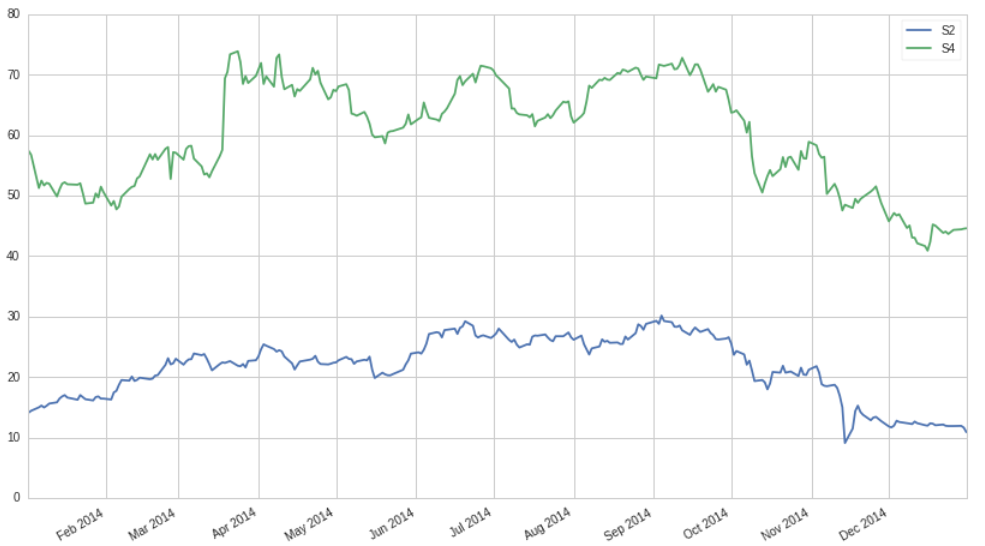

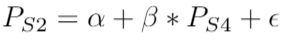

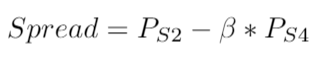

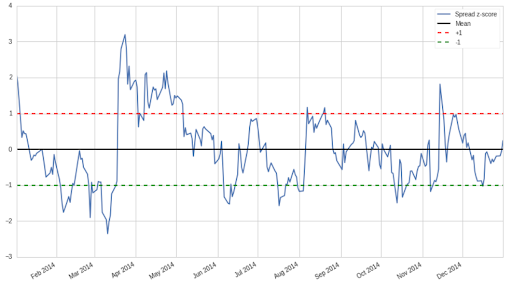

Bollinger Bands are very similar to these red and green lines we used for trading rules! Instead of a static mean, we must use a "Simple Moving Average". As an example, the 100-day SMA of APPL prices on any given day is the average APPL price over the 100 days leading up to and including that day.

In this example, we set the parameter "lookback" to 100. Another parameter is the "width", which dictates how many standard deviations separate the band from the SMA. In the example above, we can think of the "width" as 1, since the red line is 1 STD above the black line, and the green line is 1 STD below the black line. Importantly, for Bollinger Bands we calculate standard deviations from the past "lookback" days as well!

Observe in the below example how the spread stays somewhat close to the SMA, and so it remains between the bands, but it does leave now and then. Also observe how the bands tighten and widen in response to recent volatility.

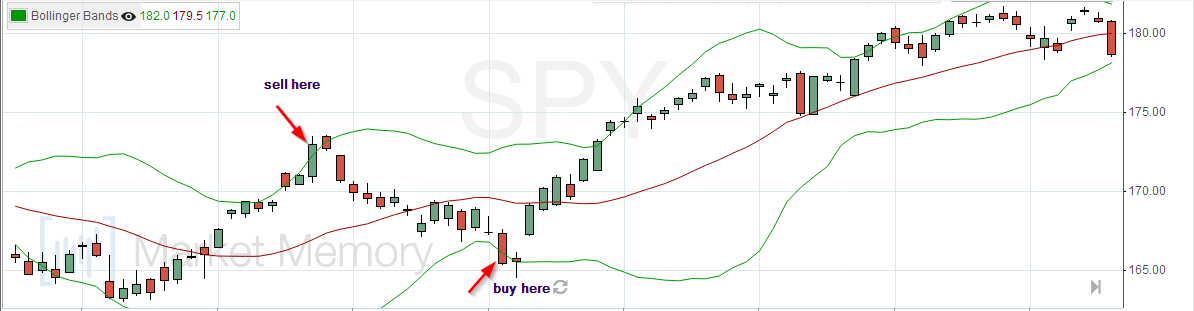

We will buy the spread when it goes below the lower BB, sell the spread when it goes above the upper BB, and exit our position whenever the spread moves back between the bands.

Note that there are many other ways of using Bollinger Bands in trading strategies. Here we present one example.  

**Game Plan and Data Setup**

We will examine two assets that we would naturally expect to be closely related: AXP (American Express Company), and BAC (Bank of America Corp.). After confirming the existence of a strong price relationship, we will devise a dynamic hedge ratio, allowing us to then calculate our spread. Then, we will create a function that runs our strategy on sample data. We can then find good values for our "lookback" and "width" parameters based on their performance on training data. We can then evaluate our strategy's overall merit by running our strategy on testing data, using the parameter choices we got from the training data.

In [29]:
# Load relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn import metrics


from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First, let's make the data workable.

In [30]:
# Read in and format data
DATA_DIR = '/content/drive/MyDrive/Maroon Capital/Maroon Capital Trading Project/'
AXP = pd.read_csv(DATA_DIR + "AXP.csv", header=0, index_col=0, parse_dates=True)
BAC = pd.read_csv(DATA_DIR + "BAC.csv", header=0, index_col=0, parse_dates=True)

print(BAC.head())
print(AXP.head())

             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2016-02-29  12.70  12.86  12.51  12.52  11.132540  123661100
2016-03-01  12.64  13.21  12.62  13.19  11.728289  153558200
2016-03-02  13.20  13.51  13.13  13.41  11.969282  139622500
2016-03-03  13.38  13.55  13.25  13.50  12.049612  105082700
2016-03-04  13.76  13.89  13.49  13.54  12.085316  171410900
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2016-02-29  55.299999  56.150002  54.810001  55.580002  50.712597  10380500
2016-03-01  56.029999  56.840000  55.619999  56.799999  51.825748   9160800
2016-03-02  56.880001  57.230000  56.570000  57.119999  52.117718   7266200
2016-03-03  57.160000  58.180000  57.160000  58.090000  53.002785   6848000
2016-03-04  58.439999  58.650002  57.810001  58.290001  53.185272   5410000


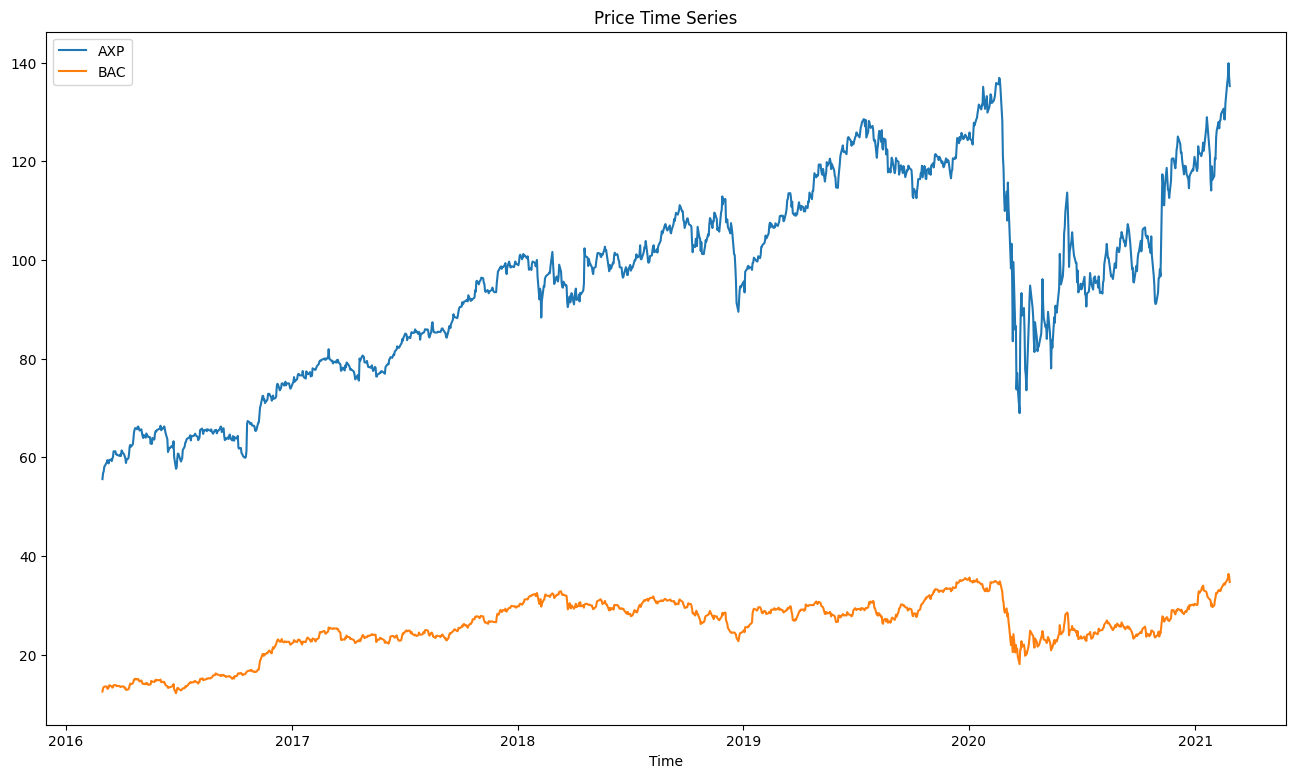

In [31]:
#plot closing price series for each asset
plt.figure(figsize=(16,9))
plt.plot(AXP['Close'], label="AXP")
plt.plot(BAC['Close'], label="BAC")
plt.xlabel("Time")
plt.legend(loc="upper left")
plt.title("Price Time Series")
plt.show()

It's clear to see that the two assets move similarly!

In [32]:
#merge the two dataframes into one dataframe and consider only data from 2016-03-01 onwards
all_data = pd.DataFrame({'AXP Close': AXP['Close'], 'BAC Close': BAC['Close']})['2016-03-01':]

#split the data into training and test sets, using a 66-33 split
cutoff = round(0.66 * len(all_data.index))
train = all_data.iloc[:cutoff]
test = all_data.iloc[cutoff:]


**Hedge Ratio**

Next, let's consider the hedge ratio. This will be an important element in our strategy – we don't want to trade our assets in a 1:1 ratio all of the time.

We will recalculate the hedge ratio daily. The hedge ratio is calculated using a line of best fit, so on any given day we need to run this linear regression on *recent data*. We have chosen to use a lookback window of 63 days of data for the hedge ratio. We then calculate the spread using the hedge ratio.

Let's see what it looks like to calculate the hedge ratio for one day.

The linear regression equation is: $AXP = \beta_0 + \beta_1BAC$

The linear regression coefficent ($\beta_1$) that we use for the hedge ratio can be calculated with the formula below.

$\beta_1 = r\frac{S_{AXP}}{S_{BAC}}$

In [34]:
lookback = 63
#the first day with enough past data for the hedge ratio calculation is the 63rd day. We'll look at the first 63 days of data then
subset_train = (train.iloc[:lookback]).copy()

#heres how we will calculate the hedge ratio in our strategy
subset_train['hedge'] = subset_train['AXP Close'].rolling(lookback).corr(subset_train['BAC Close']) * subset_train['AXP Close'].rolling(lookback).std() / subset_train['BAC Close'].rolling(lookback).std()
print(subset_train)
print('Our first hedge ratio value is', subset_train.iloc[-1, 2])

#and heres how we calculate the spread in our strategy
subset_train['spread'] = subset_train['AXP Close'] - subset_train['hedge'] * subset_train['BAC Close']
print('Our first spread is', subset_train.iloc[-1, 3])



            AXP Close  BAC Close     hedge
Date                                      
2016-03-01  56.799999      13.19       NaN
2016-03-02  57.119999      13.41       NaN
2016-03-03  58.090000      13.50       NaN
2016-03-04  58.290001      13.54       NaN
2016-03-07  59.000000      13.53       NaN
...               ...        ...       ...
2016-05-23  63.590000      14.47       NaN
2016-05-24  64.870003      14.68       NaN
2016-05-25  65.309998      14.92       NaN
2016-05-26  65.230003      14.70       NaN
2016-05-27  65.519997      14.88  3.780173

[63 rows x 3 columns]
Our first hedge ratio value is 3.7801725476552286
Our first spread is 9.2710294908902


If you think back to the spread equation and the linear regression equation we used to calculate the hedge ratio, the spread should be the intercept of our linear regression. This checks to see that our hedge ratio and spread are correct.


In [35]:
#linear regression on first 63 days' prices
z = np.polyfit(x = subset_train['BAC Close'], y = subset_train['AXP Close'], deg=1)
print('Slope: ', z[0])
print('Intercept:', z[1])

Slope:  3.7801725476550607
Intercept: 9.394494907943809


Let's plot the data to visualize the linear regression.

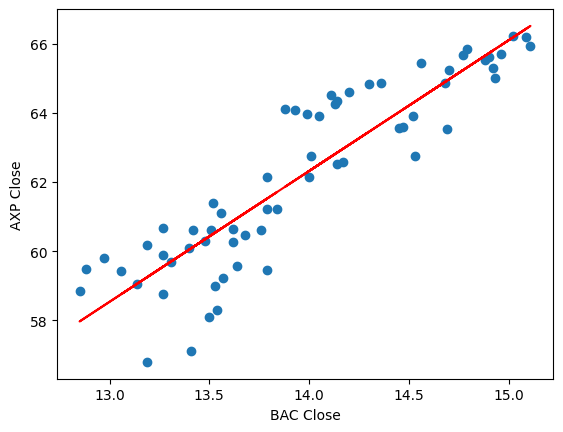

0.8054585111681152


In [36]:
X = subset_train['BAC Close'].values.reshape(-1,1)
Y = subset_train['AXP Close'].values.reshape(-1,1)
lr = LinearRegression()
lr.fit(X, Y)
Y_pred = lr.predict(X)
plt.scatter(X,Y)
plt.xlabel("BAC Close")
plt.ylabel("AXP Close")
plt.plot(X, Y_pred, color='red')
plt.show()

r2 = metrics.r2_score(Y, Y_pred) #R^2 score from linear regression
print(r2)

A hedge ratio obtained through linear regression should minimize the variance of the resulting spread, with the spread being around the "intercept" on average. Our implementation isn't perfect because we keep recalculating the hedge ratio, so the intercept keeps changing, but it will hopefully remain fairly stable so that we get a mean-reverting spread to trade on.

**Strategy Backtest**

Now that we have the hedge ratio calculation figured out, we have everything we need to implement our strategy. This function needs our price data as well as any parameters we want to optimize – in this case, lookback and width. We are setting the hedge ratio lookback to 63, so it is not being considered as a parameter.

In [37]:
def run_strategy(data, lookback, width):
   #calculating our 63-day hedge ratio lookback window like this makes our program more flexible and readable
   hr_lookback_months = int(lookback / 21)
   monthly_trading_days = 21
   hr_lookback = monthly_trading_days * hr_lookback_months

   #these are our familiar hedge ratio and spread calculations
   df = data.copy()
   df['hedge_ratio'] = df['AXP Close'].rolling(hr_lookback).corr(df['BAC Close']) * df['AXP Close'].rolling(hr_lookback).std() / df['BAC Close'].rolling(hr_lookback).std()
   df['spread'] = df['AXP Close'] - df['hedge_ratio'] * df['BAC Close']

   #BB calculations
   df['rolling_spread'] = df['spread'].rolling(lookback).mean() #lookback-day SMA of spread
   df['rolling_spread_std'] = df['spread'].rolling(lookback).std() #lookback-day rolling STD of spread
   df['upper_band'] = df['rolling_spread'] + (width * df['rolling_spread_std']) #upper = SMA + width * STD
   df['lower_band'] = df['rolling_spread'] - (width * df['rolling_spread_std']) #lower = SMA - width * STD

   #AXP position calculation: Note: AXP position is equal to our spread position
   df['Position AXP'] = np.nan #create a column for position so we can fill it
   for date in df.index:
      if df.loc[date, 'spread'] > df.loc[date, 'upper_band']:
         df.loc[date, 'Position AXP'] = -1 #sell when overperforming
      elif df.loc[date, 'spread'] < df.loc[date, 'lower_band']:
         df.loc[date, 'Position AXP'] = 1 #buy when underperforming
      elif (df.loc[date, 'spread'] >= df.loc[date, 'lower_band']) & (df.loc[date, 'spread'] <= df.loc[date, 'upper_band']):
         df.loc[date, 'Position AXP'] = 0 #hold when inside bands

   #This is our BAC position calculatio:
   df['Position BAC'] = -df['hedge_ratio'] * df['Position AXP']

   #Daily pnl calculation. The pnl of today is today's position * (tomorrow's price - today's price)
   #We are calculating the impact of today's trading decision.
   df['P&L AXP'] = df['Position AXP'] * (df['AXP Close'].diff().shift(-1))
   df['P&L BAC'] = df['Position BAC'] * (df['BAC Close'].diff().shift(-1))

   df['P&L'] = df['P&L AXP'] + df['P&L BAC']

   return df

Relevant Performance Metrics on Training Data

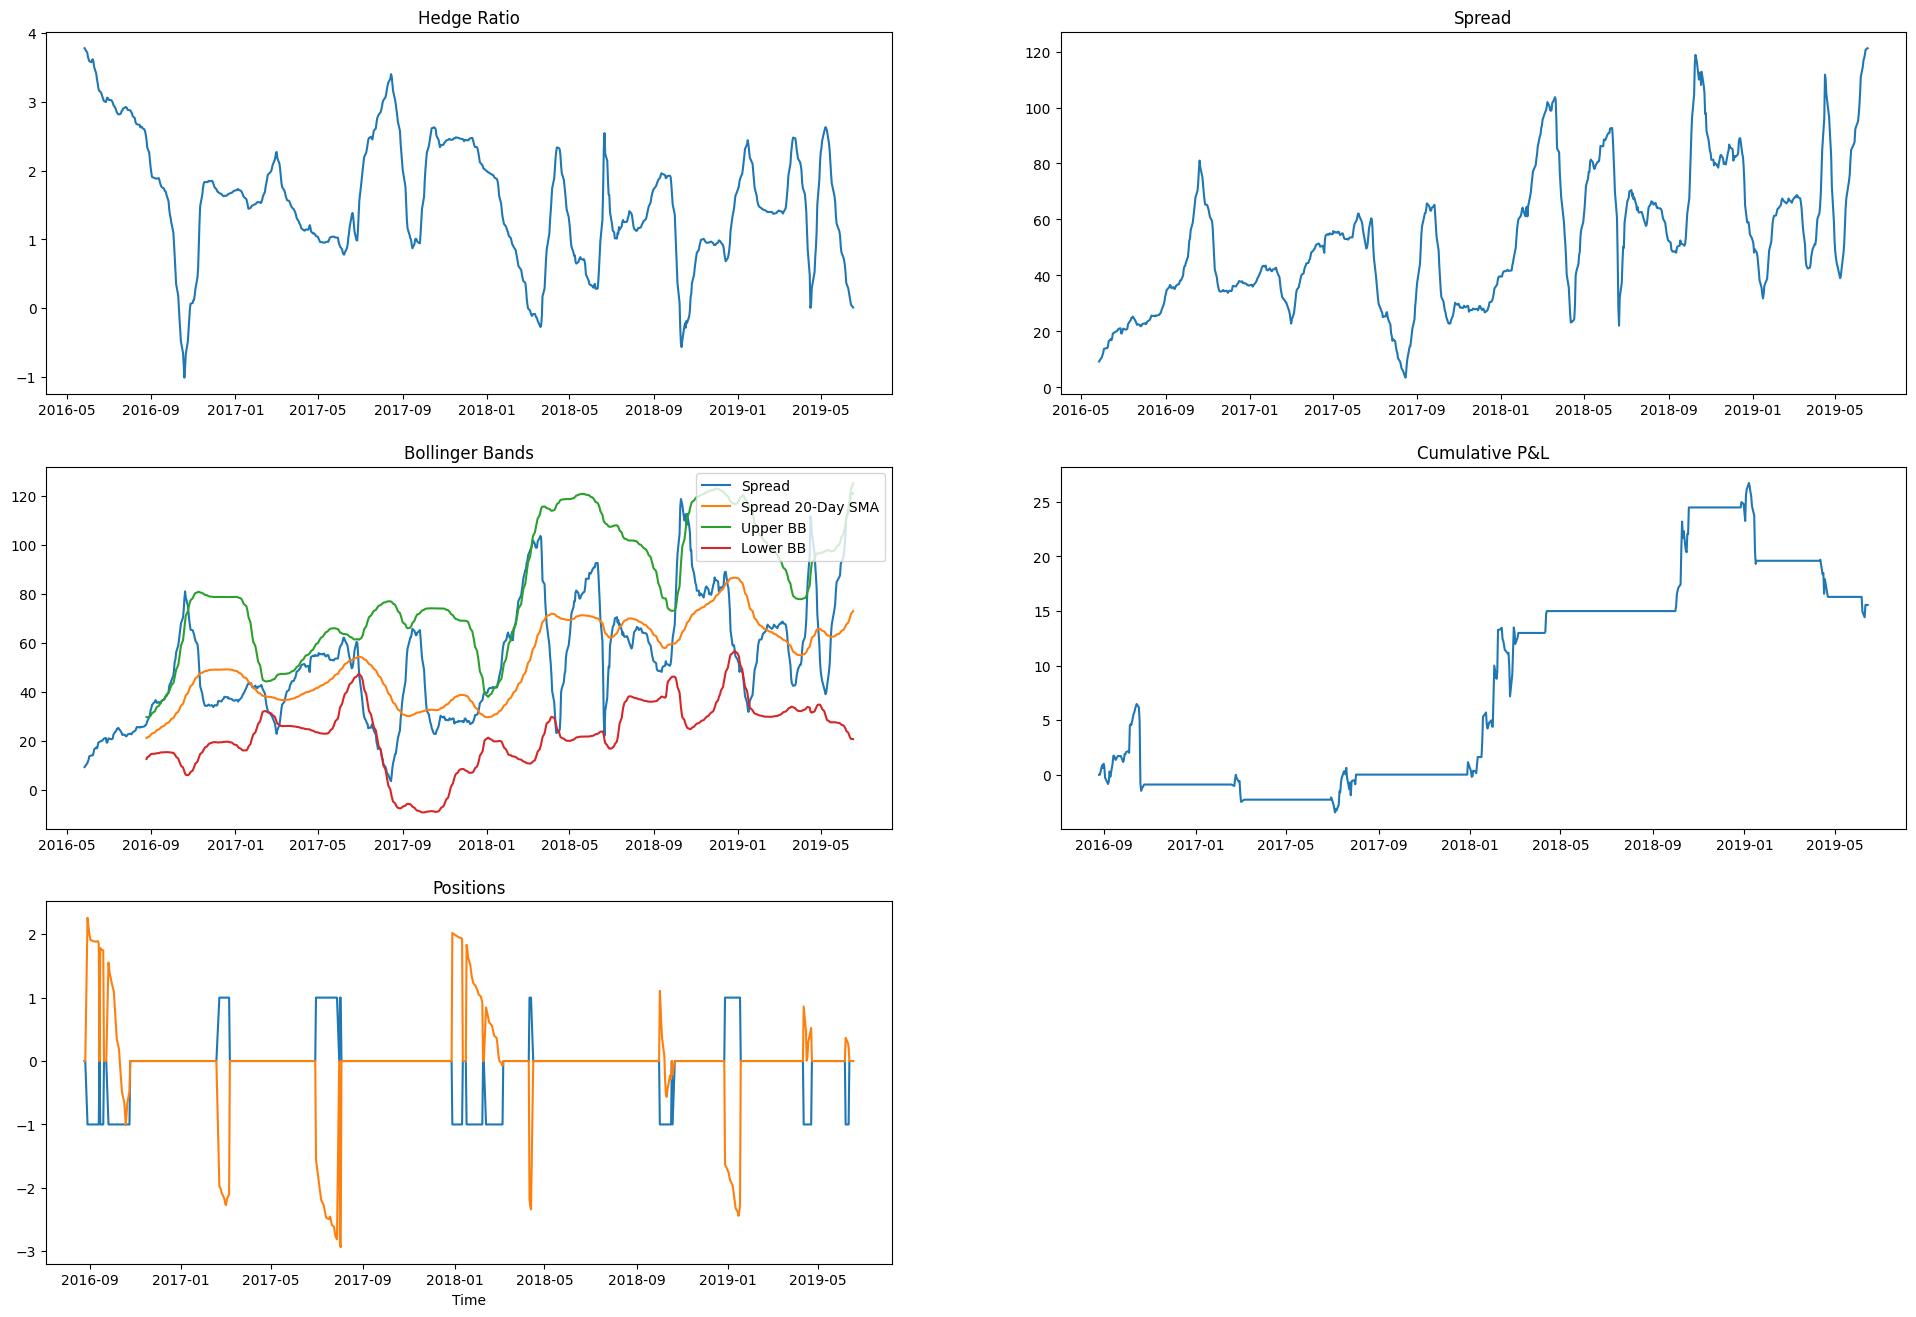

In [38]:
standard_BB_train_df = run_strategy(train, lookback, 2) #20-day and 2 STD are the standard BB parameters used

#plot intermediate and final results of using these parameters on training data
fig = plt.figure(figsize=(24,16)) #overall plot size
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

ax1.plot(standard_BB_train_df['hedge_ratio'])
ax1.set_title("Hedge Ratio")

ax2.plot(standard_BB_train_df['spread'])
ax2.set_title("Spread")

ax3.plot(standard_BB_train_df['spread'], label = 'Spread')
ax3.plot(standard_BB_train_df['rolling_spread'], label = 'Spread 20-Day SMA')
ax3.plot(standard_BB_train_df['upper_band'], label = 'Upper BB')
ax3.plot(standard_BB_train_df['lower_band'], label = 'Lower BB')
ax3.set_title("Bollinger Bands")
ax3.legend(loc="upper right")

ax4.plot(standard_BB_train_df['P&L'].cumsum()) #note: we use cumsum here to see *cumulative* profit
ax4.set_title("Cumulative P&L")

ax5.plot(standard_BB_train_df['Position AXP'], label = "AXP")
ax5.plot(standard_BB_train_df['Position BAC'], label = "BAC")
ax5.set_title("Positions")

plt.xlabel("Time")
plt.show()

Relevent Performance Metrics on Testing Data

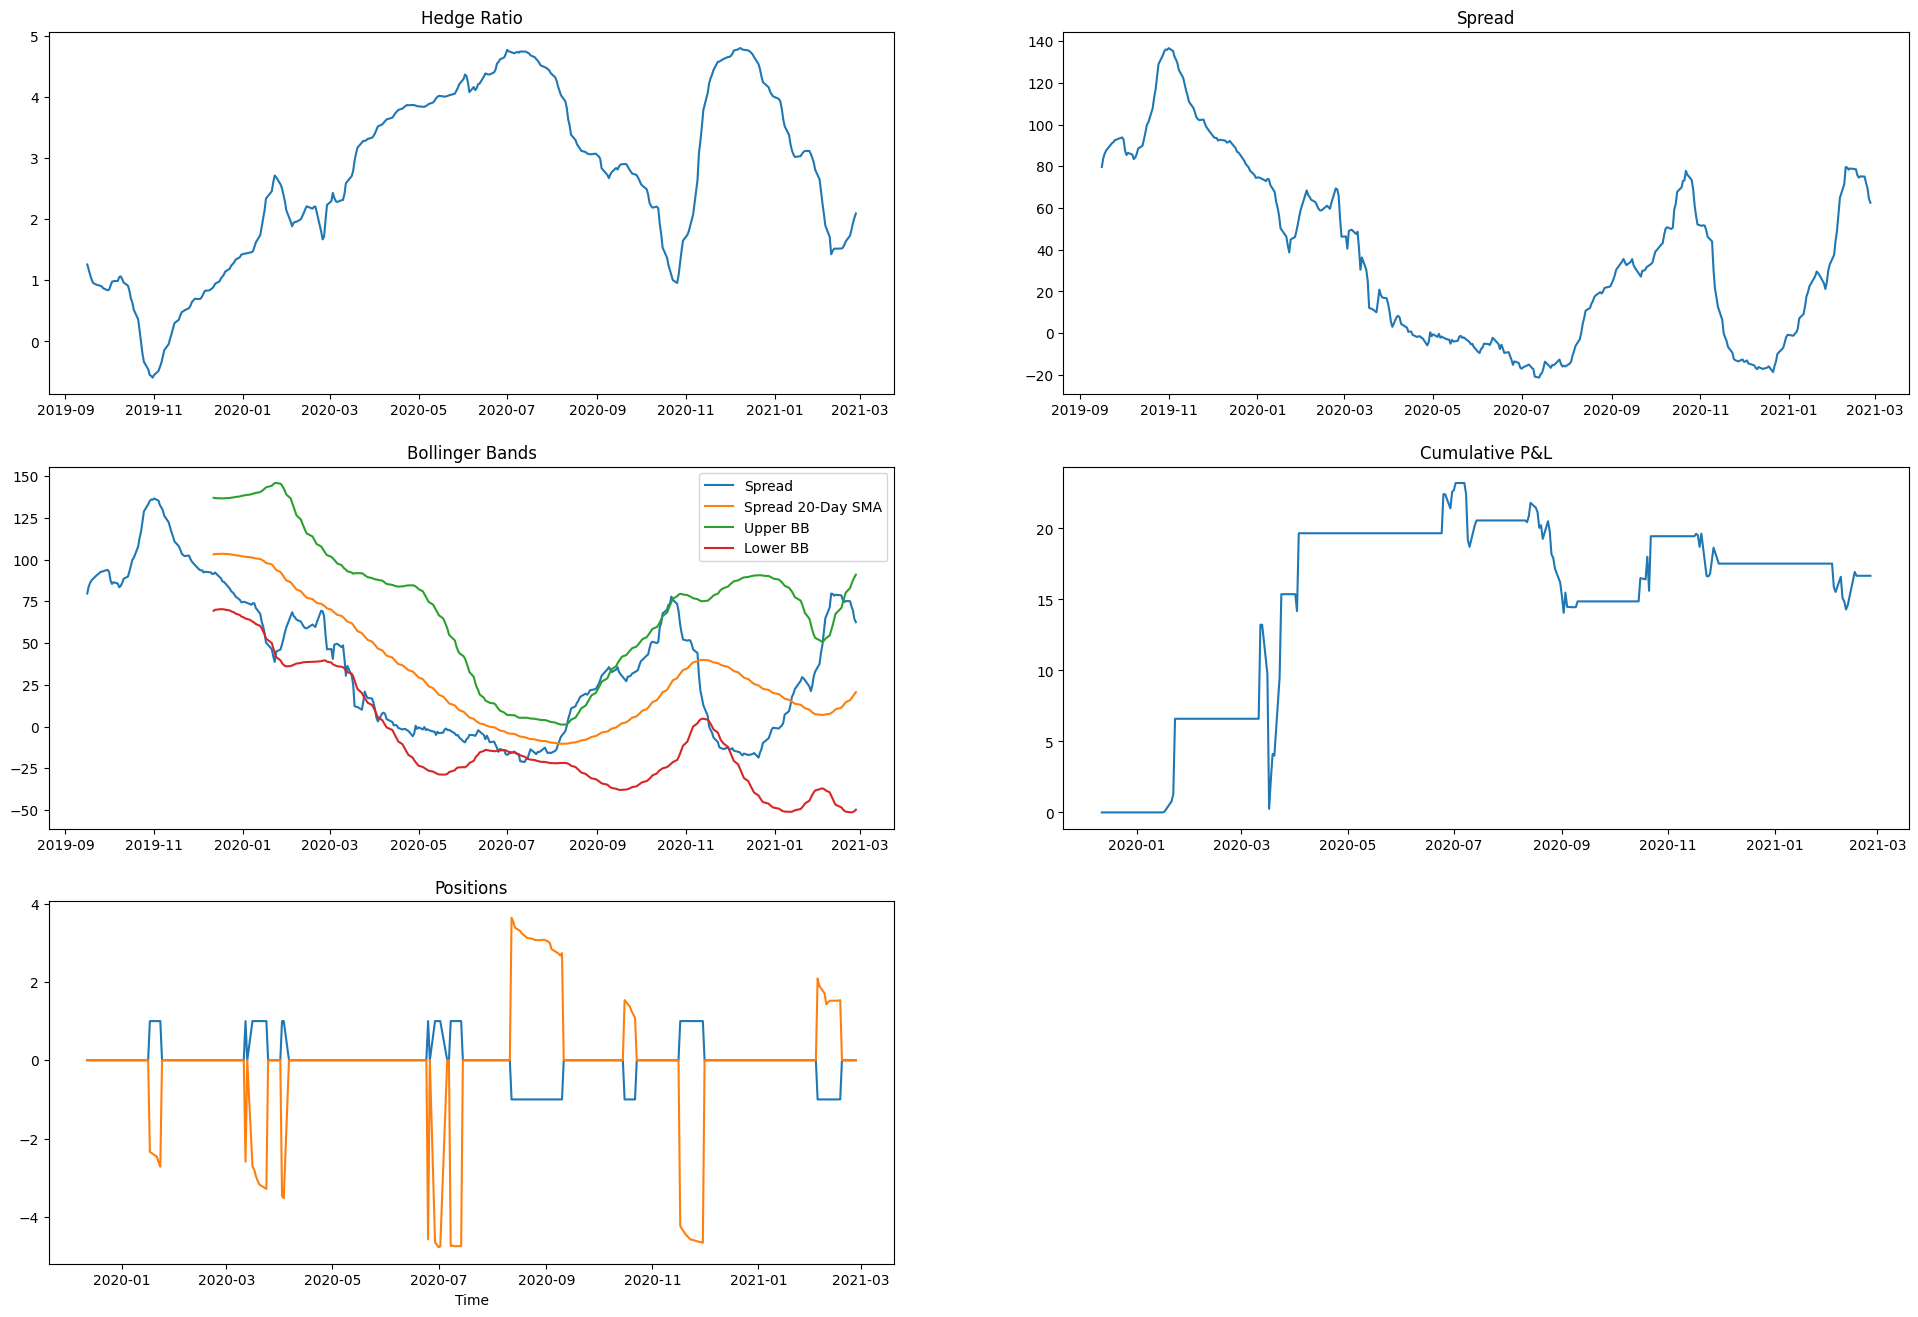

In [39]:
standard_BB_test_df = run_strategy(test, lookback, 2) #20-day and 2 STD are the standard BB parameters used

#plot intermediate and final results of using these parameters on training data
fig = plt.figure(figsize=(24,16)) #overall plot size
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

ax1.plot(standard_BB_test_df['hedge_ratio'])
ax1.set_title("Hedge Ratio")

ax2.plot(standard_BB_test_df['spread'])
ax2.set_title("Spread")

ax3.plot(standard_BB_test_df['spread'], label = 'Spread')
ax3.plot(standard_BB_test_df['rolling_spread'], label = 'Spread 20-Day SMA')
ax3.plot(standard_BB_test_df['upper_band'], label = 'Upper BB')
ax3.plot(standard_BB_test_df['lower_band'], label = 'Lower BB')
ax3.set_title("Bollinger Bands")
ax3.legend(loc="upper right")

ax4.plot(standard_BB_test_df['P&L'].cumsum()) #note: we use cumsum here to see *cumulative* profit
ax4.set_title("Cumulative P&L")

ax5.plot(standard_BB_test_df['Position AXP'], label = "AXP")
ax5.plot(standard_BB_test_df['Position BAC'], label = "BAC")
ax5.set_title("Positions")

plt.xlabel("Time")
plt.show()

<ipython-input-40-4b2fe552a2e6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['capital'] = capital
<ipython-input-40-4b2fe552a2e6>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['capital'] -= (df['Position BAC'].diff() * df['BAC Close']).cumsum()
<ipython-input-40-4b2fe552a2e6>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

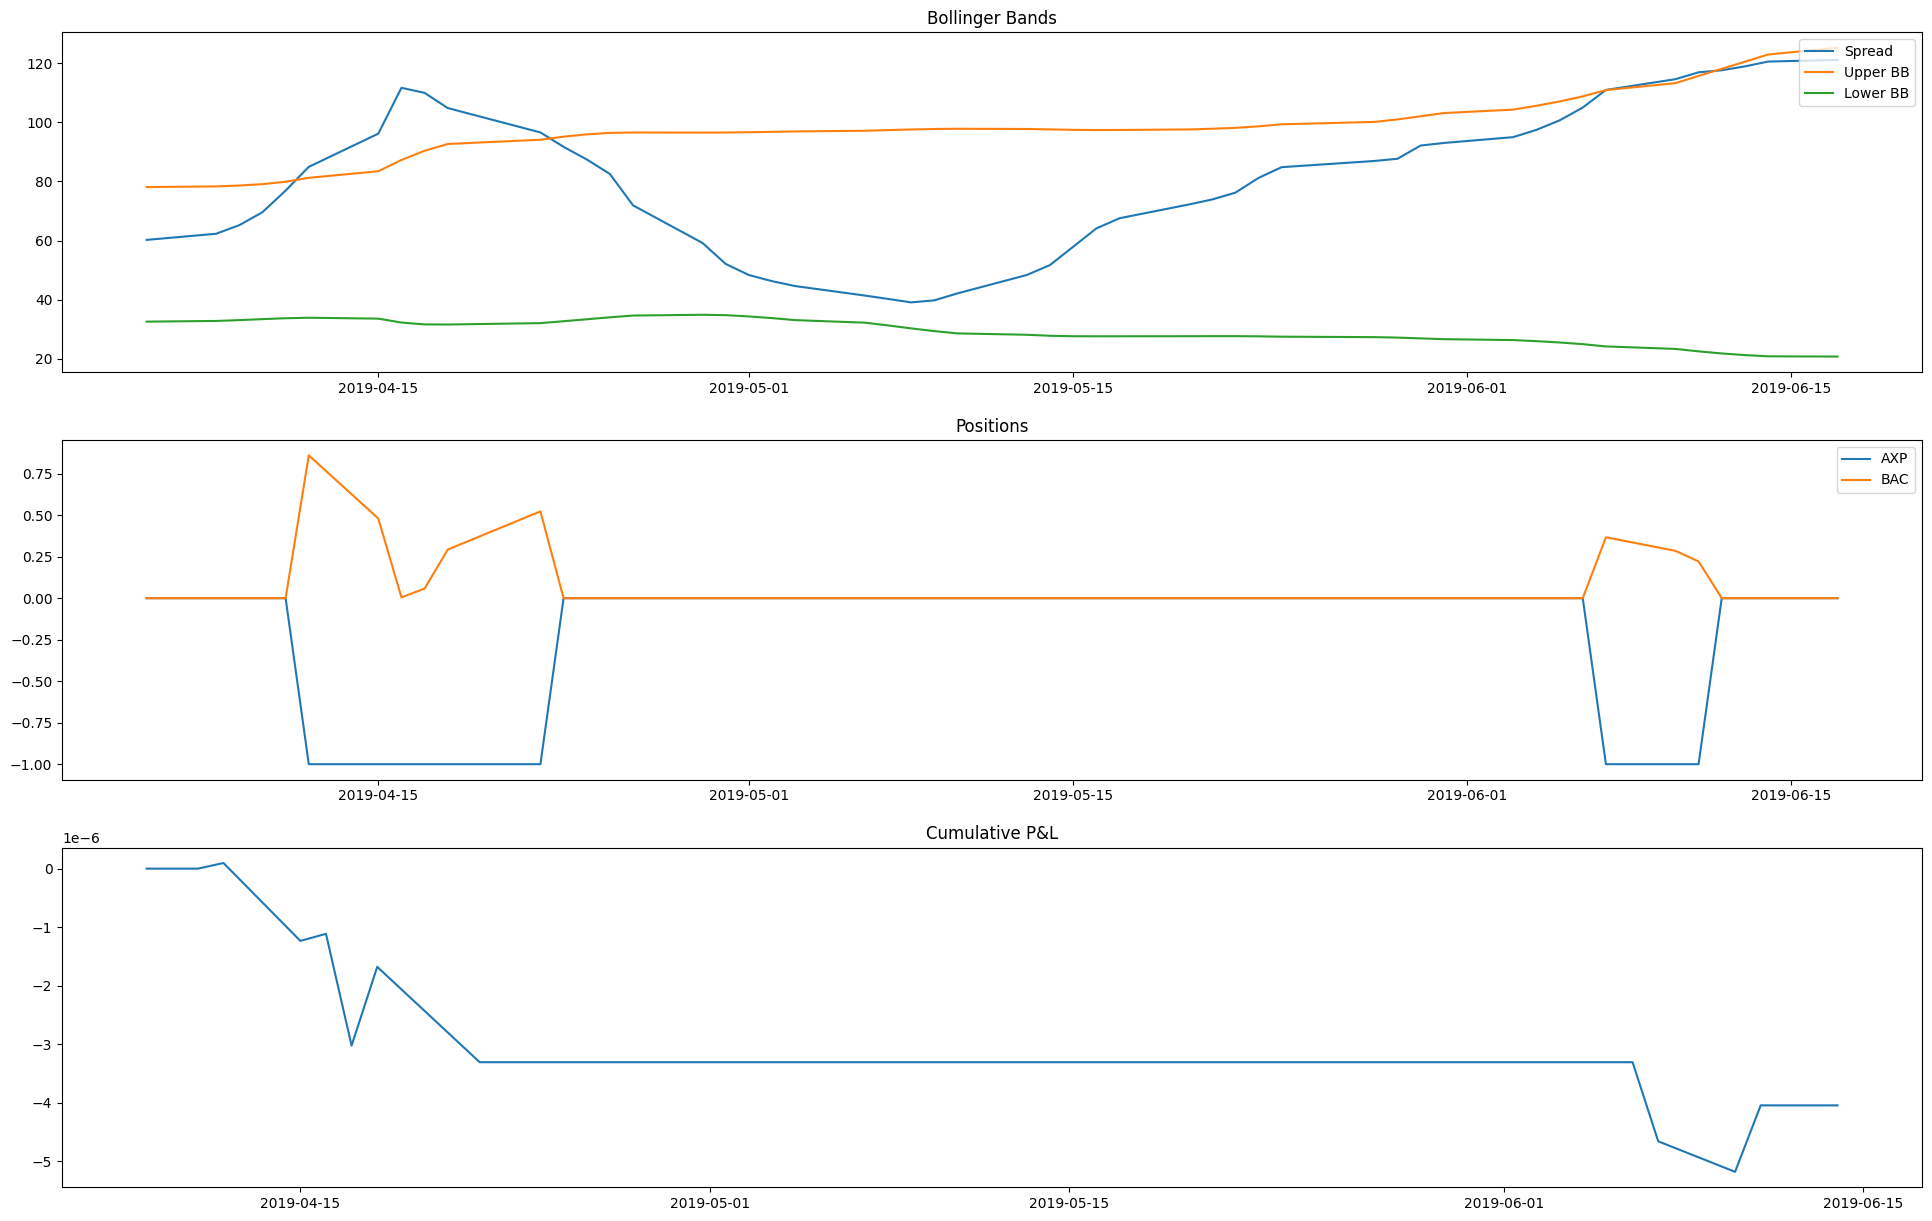

In [40]:
last_fifty = standard_BB_train_df.iloc[-50:]
fig = plt.figure(figsize=(24,15))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(last_fifty['spread'], label = 'Spread')
ax1.plot(last_fifty['upper_band'], label = 'Upper BB')
ax1.plot(last_fifty['lower_band'], label = 'Lower BB')
ax1.set_title("Bollinger Bands")
ax1.legend(loc="upper right")

ax2.plot(last_fifty['Position AXP'], label = "AXP")
ax2.plot(last_fifty['Position BAC'], label = "BAC")
ax2.set_title("Positions")
ax2.legend(loc="upper right")

def calculate_pnl_from_starting_capital(df, capital=1000000):
  df['capital'] = capital
  df['capital'] -= (df['Position BAC'].diff() * df['BAC Close']).cumsum()
  df['capital'] -= (df['Position AXP'].diff() * df['AXP Close']).cumsum()

  df['position_value'] = (df['Position AXP'] * df['AXP Close'].shift(-1) + df['Position BAC'] * df['BAC Close'].shift(-1))
  df['portfolio_value'] = df['capital'] + df['position_value']
  df['Returns'] = (df['portfolio_value'] - capital) / capital
  df['P&L'] = df['Returns'].diff()

calculate_pnl_from_starting_capital(last_fifty)
ax3.plot(last_fifty['P&L'].cumsum()) #note: we use cumsum here to see *cumulative* profit
ax3.set_title("Cumulative P&L")

plt.show()

<ipython-input-41-5f33930af2ed>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['capital'] = capital
<ipython-input-41-5f33930af2ed>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['capital'] -= (df['Position BAC'].diff() * df['BAC Close']).cumsum()
<ipython-input-41-5f33930af2ed>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

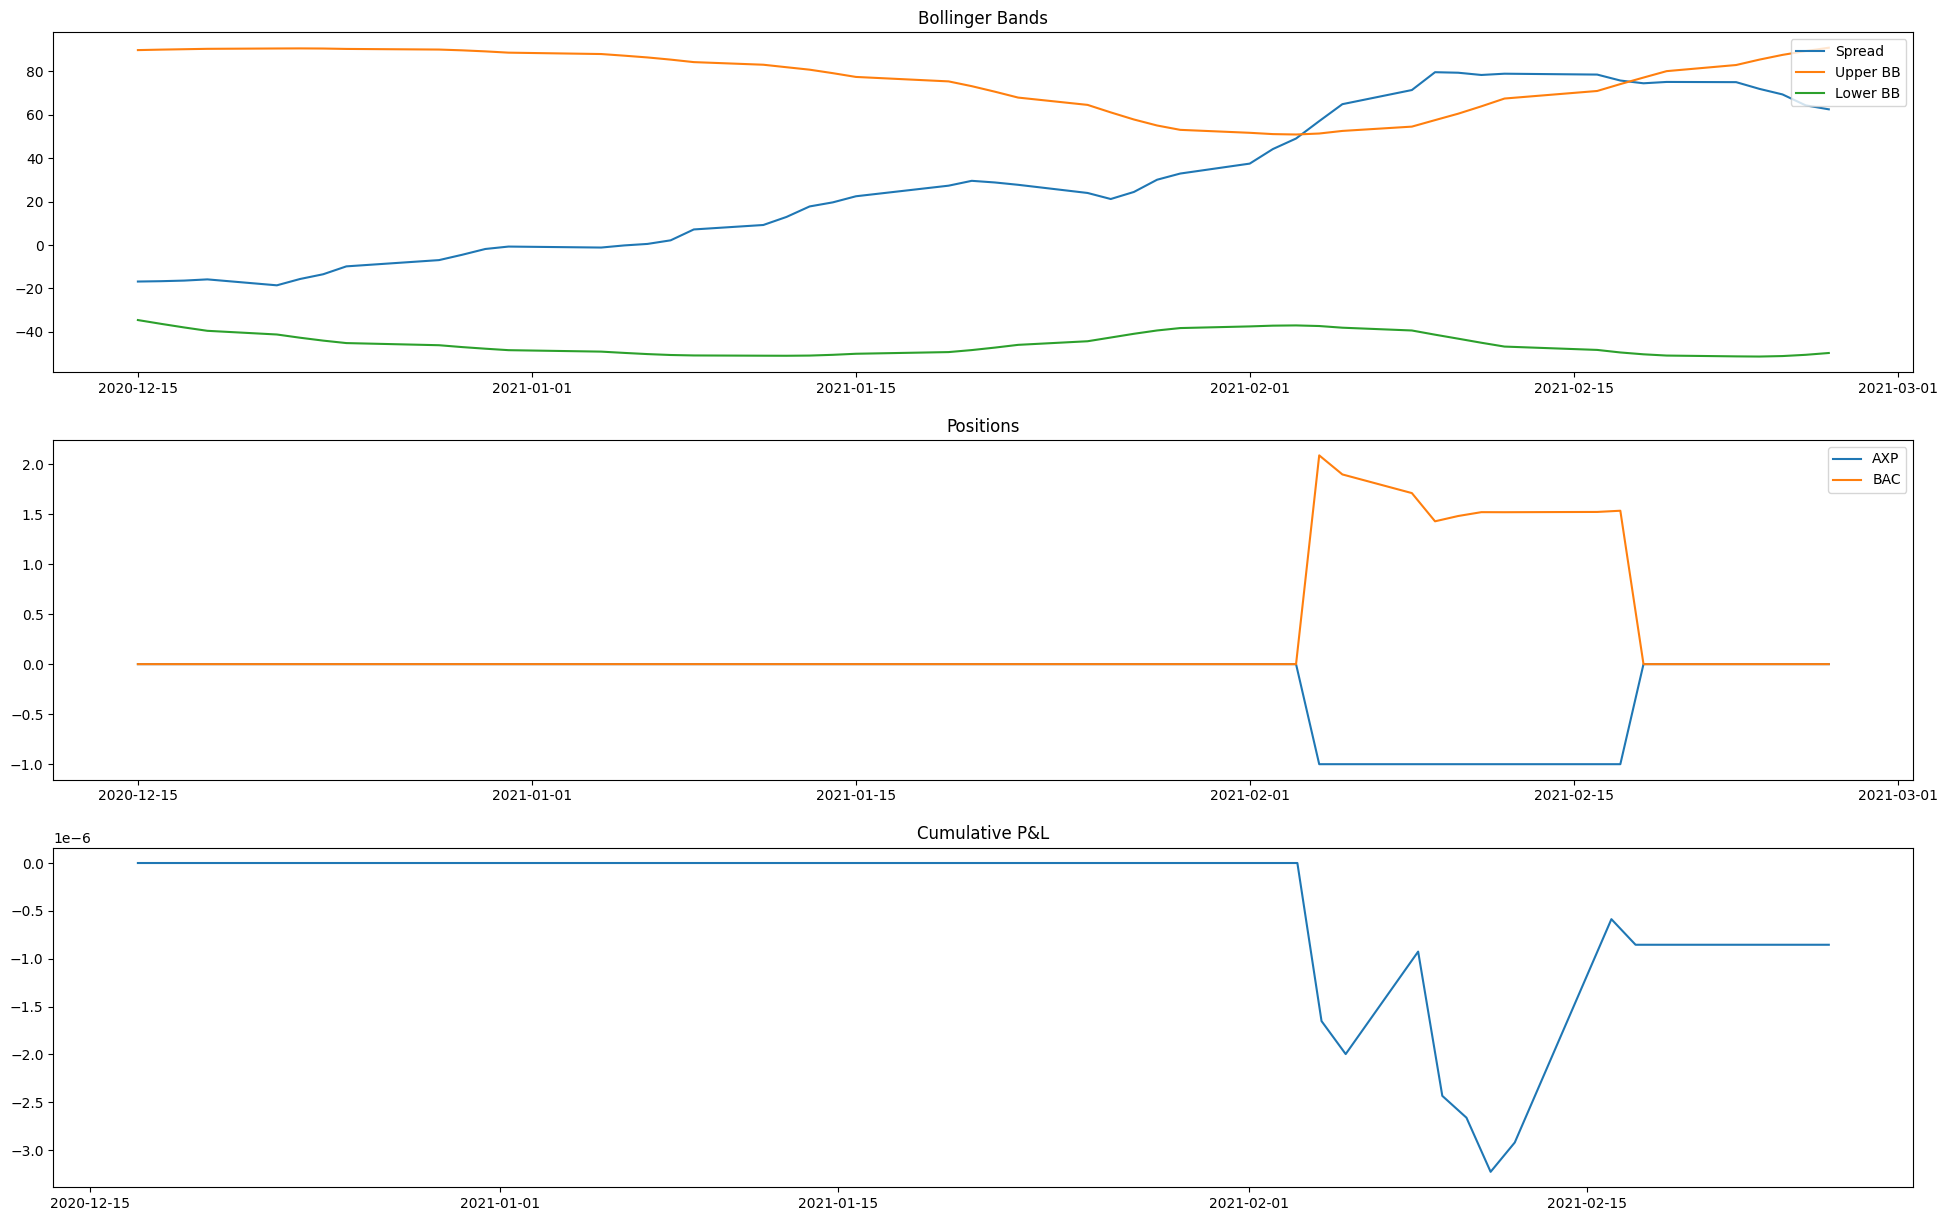

In [41]:
last_fifty = standard_BB_test_df.iloc[-50:]
fig = plt.figure(figsize=(24,15))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(last_fifty['spread'], label = 'Spread')
ax1.plot(last_fifty['upper_band'], label = 'Upper BB')
ax1.plot(last_fifty['lower_band'], label = 'Lower BB')
ax1.set_title("Bollinger Bands")
ax1.legend(loc="upper right")

ax2.plot(last_fifty['Position AXP'], label = "AXP")
ax2.plot(last_fifty['Position BAC'], label = "BAC")
ax2.set_title("Positions")
ax2.legend(loc="upper right")

def calculate_pnl_from_starting_capital(df, capital=1000000):
  df['capital'] = capital
  df['capital'] -= (df['Position BAC'].diff() * df['BAC Close']).cumsum()
  df['capital'] -= (df['Position AXP'].diff() * df['AXP Close']).cumsum()

  df['position_value'] = (df['Position AXP'] * df['AXP Close'].shift(-1) + df['Position BAC'] * df['BAC Close'].shift(-1))
  df['portfolio_value'] = df['capital'] + df['position_value']
  df['Returns'] = (df['portfolio_value'] - capital) / capital
  df['P&L'] = df['Returns'].diff()

calculate_pnl_from_starting_capital(last_fifty)
ax3.plot(last_fifty['P&L'].cumsum()) #note: we use cumsum here to see *cumulative* profit
ax3.set_title("Cumulative P&L")

plt.show()

Are there better ways of going about our hedge ratio calculation? Could we parameterize a lookback window and/or a recalcualtion frequency for it? What if transaction costs are factored in – how would we edit our run_strategy function, and how would that impact our optimal parameters and our hedge ratio choices? How can we quantify our confidence in the mean-reverting property of our spread? Any creative ways to edit the overall strategy logic?